<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Architecture" data-toc-modified-id="Architecture-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Architecture</a></span><ul class="toc-item"><li><span><a href="#Name:-&quot;super_hydro&quot;" data-toc-modified-id="Name:-&quot;super_hydro&quot;-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Name: "super_hydro"</a></span></li></ul></li><li><span><a href="#General-Structure" data-toc-modified-id="General-Structure-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>General Structure</a></span></li><li><span><a href="#Programming-API" data-toc-modified-id="Programming-API-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Programming API</a></span></li><li><span><a href="#Configuration" data-toc-modified-id="Configuration-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Configuration</a></span></li><li><span><a href="#Communication" data-toc-modified-id="Communication-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Communication</a></span></li><li><span><a href="#Logging" data-toc-modified-id="Logging-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Logging</a></span></li><li><span><a href="#Synchronization" data-toc-modified-id="Synchronization-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Synchronization</a></span></li><li><span><a href="#Potential" data-toc-modified-id="Potential-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Potential</a></span></li><li><span><a href="#References" data-toc-modified-id="References-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Architecture

Here we describe our basic architecture of our application, including configuration and communication protocols.  Our application consists of a server and multiple clients.  The server performs the computation, while the clients display the results and provide real-time inputs and controls.

For stability, we use [ØMQ] via the [pyzmq](https://pyzmq.readthedocs.io/en/latest/) library to implement the base level communication layer and define a simple protocol.

[ØMQ]: http://zeromq.org

## Name: "super_hydro"

As of 9 September 2018, there are only 69 matches on Google for the search term ["super_hydro"](https://www.google.com/search?q=%22super_hydro%22) (with quotes) and most are squirreled away (email addresses, etc.)  This seems like a safe choice for a project name.  For comparison ["SuperHydro"](https://www.google.com/search?q=%22SuperHydro%22) returned about 21k matches.

* Environment variables will be prefixed with `SUPER_HYDRO_` to minimize conflicts.
* The main module is `super_hydro`.
* Config files will use `super_hydro`.

# General Structure

The application is divided into three logical components:

* **Computation Server**: This is the high-performance python application that does the actually superfluid evolution.  It generally will run on a fairly high-performance computer with a GPU accelerator, but could be launched by the client if needed.  The computation server provides an interface through which clients can interact with it, requesting quantities like the density for display, and setting parameters in response to users.  Multiple clients can connect to the computation server, possibly controlling different aspects of the simulation.

   Clients will interact with the computation server through the `IServer` interface.  This is provided by the following classes:
   
   * `super_hydro.server.Server`: Direct interface to a running computation server.  This can be used by python clients that launch a computation server themselves.
   * `super_hydro.communication.NetworkServer`: Provides a network interface through which python clients can communicate with a running server vi TCP/IP.
   
* **Client**: The client provides a front-end for the user, displaying the evolution, and providing controls through which the user can interact with the computation server.

# Programming API

The code is structured into three logical units, each defined in a separate submodule.  Interfaces are defined in `super_hydro.interfaces`.

* **`super_hydro.physics`**: This modules contains all of the physics.  Components here define a `Model` class that implements the `supero_hydro.interfaces.IModel` interface defining a particular physics problem.  All of the detailed computations are described in these files.

* **`super_hydro.server`**: This is the computation server.  It will run the computation engine, and listen for connection requests from clients who want to interact or view the simulation.  The server should generally be run on a fairly high-performance computer – ideally equipped with an NVIDIA GPU.

* **`super_hydro.client`**: This is the client.  Clients are generally designed to be lightweight in both their dependencies and performance characteristics so that clients can be installed and run on as many platforms as possible, including mobile devices.  A more heavyweight client might be designed that offloads some of the calculations to improve UI performance.  For example, updating tracer-particle positions so that they move smoothly even if background frame updates are slow due to network issues.  I would really like to make a web-client, but have not yet found a suitable framework.

Current Configuration:
* May 2019: The client is written in python using [Kivy](https://kivy.org/#home).  This works reasonably well, but has some limitations with configuration and installation.  The server currently performs all computations, including tracer-particles and incorporates these into the image displayed on the clients.

# Configuration

Configuration takes place in several layers.  From lowest to highest precedence, we have:

1. **Defaults hard-coded into the program:** These are coded in the `params` dictionaries of the physics models.  See for example `physics/gpe.py::GPEBase`.
2. **Environmental variables:**
3. **Configuration files:**
4. **Command-line options:** E.g.:

   ```bash
   conda activate super_hydro
   python bin/server --model=gpe.BECBreather --Nx=256 Ny=256
   ```

The [ConfigArgParse](https://github.com/bw2/ConfigArgParse) library seems to provide this behavior out of the box, so we start with this.  A couple of comments:

* Options with a long name `--option` can be set in a config file with the same name.
* Options without `-` or `--` are positional.
* Sections are not used (by design) but can be included as comments in the config files.

Configuration options are specified in the [`super_hydro/config.py`](/edit/super_hydro/config.py) file which reads these from various config files (`~/.config/super_hydro.conf` or `./super_hydro.conf` preferred), environment variables, or command-line arguments.

*An alternative [strategy suggested by Von Welch](http://blog.vwelch.com/2011/04/combining-configparser-and-argparse.html) combines [`configparser`](https://docs.python.org/3/library/configparser.html) for reading the config files with [`argparse`](https://docs.python.org/3/library/argparse.html) for processing the command line.*

To configure the communication layer, the server must have an IP address (URL) specifying where it is located, and a port on which it listens for connections.  These are specified in the application config file.

# Communication

The main communication pathway is between the server, which runs the computation, and the client, which provides the visualization and interaction.  This communication will generally take place across a network (using [ØMQ]) which allows the server to run on high-performance hardware, but to simplify development and debugging, we also provide a direction python connection so that a seperate server need not be run.

Communication between the client and server is driven by the clients through a [request-reply](http://zguide.zeromq.org/page:all#Messaging-Patterns) pattern where the client requests actions of or data from the server.  This interface is defined through the following methods of the server:

* `do(msg)`:
* `get(msg)`:
* `set(msg, obj)`:
* `get_array(msg)`: Sending arrays requires a bit more work, so we separate these methods.
* `set_array(msg, array)`:


* `do_*`: Simple request for the server to do something such as start, stop, pause, resume, etc.  No arguments are passed other than the byte-string such as `b'do_start'`.
* `set_*`: Set a variable on the server.  This allows the client to set a parameter of the server such as the cooling, position of the external potential, etc.  The message to the server contains two parts: first the byte-string such as `b'set_cooling'` is sent.  Once the server responds, the client sends the data in a JSON encoding.
* `set_array_*`: 
* `get_*`: Get a variable from the server.  The message to the server contains two parts: first the byte-string such as `b'set_cooling'` is sent.  Once the server responds, the client sends the data in a JSON encoding.

One special sentinel value is used: string starting with `b'Error: '` which will indicate that the command failed.


[ØMQ]: http://zeromq.org

To simplify communication we use [ØMQ] via the [pyzmq](https://pyzmq.readthedocs.io/en/latest/) library to implement the base level communication layer and define a simple protocol through `Client` and `Server` classes in [`super_hydro/communication.py`](/edit/super_hydro/communication.py).

Currently we used the [**Request-reply**](http://zguide.zeromq.org/page:all#Messaging-Patterns) pattern where the client drives all communication through a `send()/recv()` pair and the server responds with a `recv()/send()` pair.  We implement the following transactions, initiated by the client: 

*(Unless otherwise specified, all data discussed must be [`bytes`](https://docs.python.org/3/library/stdtypes.html#bytes) objects (ascii strings) which can be sent without encoding.)*

* **Request:** The client requests something from the server by sending a message.  This could be a request for simple information or to perform an action such as **Pause**.  The server responds with a simple message.

  * **Client->Server**: `bytes`
  * **Server->Client**: `bytes`

  ```python
  # Python eg
  client.send(msg)
  response = client.recv()
  ```

* **Get:** The client requests for some encoded data to be returned.

  * **Client->Server**: `bytes`
  * **Server->Client**: (`bytes`, `data`)

  ```python
  client.send(msg)
  result = client.recv_json()
  ```

* **Send:** The client sends encoded data to the server.

  ```python
  client.send(msg)
  response = client.recv_json()
  client.send_json(data)
  response = client.recv_json()
  ```


* **GetArray:** The client requests an array.  For efficiency we provide a custom encoding for arrays:

  ```python
  client.send(msg)
  result = client.recv_array()
  ```
  
* **SendArray:** The client sends an array to the server.  For efficiency we provide a custom encoding for arrays:

  ```python
  client.send(msg)
  response = client.recv()
  client.send_array(data))
  response = client.recv()
  ```  
  
[ØMQ]: http://zeromq.org

Note: all messages should be byte objects, not strings (i.e. `msg=b"Window.size"` not `msg="Window.size"`).

Data (`obj`s) are serialized using `send_json` and `recv_json` except for NumPy arrays which have custom serializations as suggested in the [pyzmq docs](https://pyzmq.readthedocs.io/en/latest/serialization.html?highlight=buffer).

Currently the code employs the `zmq.REQ` (Server) and `zmq.REP` (Client) socket types for which each message requires a send and receive.  This is simply [described here](https://learning-0mq-with-pyzmq.readthedocs.io/en/latest/pyzmq/patterns/client_server.html) but may not allow multiple clients to connect to the server.  (It definitely allows a client to connect with multiple servers, but this is not the pattern we want.)

In [ ]:
import numpy as np
A = np.random.random((128, 128)) + 1j
%timeit A.tostring()
%timeit A.tobytes()

In [ ]:
s = A.tobytes()
B = np.frombuffer(A, dtype=complex).reshape(A.shape)
C = np.frombuffer(s, dtype=complex).reshape(A.shape)
assert np.allclose(A, C)
assert np.allclose(A, B)

%timeit np.frombuffer(A, dtype=complex).reshape(A.shape)
%timeit np.frombuffer(s, dtype=complex).reshape(A.shape)

In [ ]:
# Here you can test what types of objects have simple json reps.
import json

json.dumps({'a': "Unknown"})

# Logging

Logging is currently done through the [`logging`](https://docs.python.org/3/library/logging.html) module through the `Logger` class in [`super_hydro/utils.py`](/edit/super_hydro/utils.py).  Two mechanisms are provided in the code:

* Output a message at a specified logging level (default is INFO):

  ```python
  log(msg, level=logging.INFO)
  ```
  
* Frame a task with messages at the start and end with a specified logging level:

  ```python
  with log_task(msg, level=logging.INFO):
      ...
  ```

For the clients, we might want to use the logging facilities of the front end.

# Synchronization

Here we discuss some synchronization strategies:

* **Client Driven**: This is how the current version of the code works.  The server advances the simulation by the specified number of `steps` every time the client asks the server to `get(b"Density")`.  This is done using `kivy.clock.Clock.schedule_interval`.  The advantage of this is that the clients (who do the visualization) never miss a frame.  The disadvantage is that the simulation is slowed down since it must work in lock-step with the client, communication, etc.

* **Server Driven**: In this case, the server might run as fast as possible, and the clients just update when they can.

# Potential

Populating the interactive namespace from numpy and matplotlib


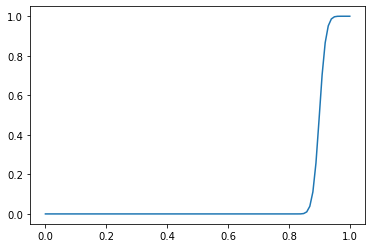

In [1]:
import sys
sys.path.append('..')
%pylab inline --no-import-all
from super_hydro import utils
x = np.linspace(0,1,100)
plt.plot(x, utils.mstep(x-0.8, 0.2))

# References

* [Which is the best way to allow configuration options be overridden at the command line in Python?
](https://stackoverflow.com/questions/3609852/which-is-the-best-way-to-allow-configuration-options-be-overridden-at-the-comman/5826167)
* https://github.com/lebedov/msgpack-numpy